# Notebook untuk [Dataset Barcode and QR](https://www.kaggle.com/datasets/jonathanimmanuel/barcode-and-qr).

## Pendahuluan

Jupyter Notebook ini berfungsi sebagai dokumentasi dan alur kerja untuk bekerja dengan Dataset Barcode and QR. Dataset dapat ditemukan di Kaggle dan berisi gambar barcode dan QR code.

Dalam notebook ini, kita akan menjelajahi dataset, memproses gambar, membangun model prediktif menggunakan Convolutional Neural Network, dan mengevaluasi kinerja model menggunakan berbagai metrik, seperti akurasi, confusion matrix, dan laporan klasifikasi.

Mari kita mulai!

### Notebook dibuat oleh: [Jonathan Immanuel](https://www.kaggle.com/jonathanimmanuel)

## Daftar Isi
### 1. [Exploratory Data Analysis](#eda)
    - 1.1 Mengimpor Pustaka
    - 1.2 Memuat Dataset
    - 1.3 Mengeksplorasi Dataset
    - 1.4 Visualisasi Data
### 2. [Data Preprocessing](#preprocess)
    - 2.1 Normalisasi Gambar
    - 2.2 Membagi Data
### 3. [Membangun Model](#model)
    - 3.1 Membangun Arsitektur Model
    - 3.2 Melatih Model
### 4. [Evaluasi Model](#evaluate)
    - 4.1 Akurasi
    - 4.2 Confusion Matrix
    - 4.3 Laporan Klasifikasi
### 5. [Pembahasan](#conclusion)

## 1. Exploratory Data Analysis <a id="eda"></a>
### 1.1 Mengimpor Pustaka

Mari kita mulai dengan mengimpor pustaka yang diperlukan untuk notebook ini.
- `numpy` untuk operasi numerik
- `pandas` untuk manipulasi data
- `matplotlib` untuk visualisasi data
- `seaborn` untuk visualisasi data
- `tensorflow` untuk membangun model
- `sklearn` untuk evaluasi model

In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

### 1.2 Memuat Dataset

Setelah itu, kita akan memuat dataset menggunakan pustaka `tensorflow`.
Kita membuat konstanta untuk ukuran gambar dan ukuran batch yang akan digunakan nanti di notebook ini.

In [2]:
IMG_WIDTH = 400
IMG_HEIGHT = 400
BATCH_SIZE = 32
EPOCHS = 15
CLASS_NAMES = ['barcode', 'both', 'qr']

Anda dapat mengunduh dataset dari [sini](https://www.kaggle.com/datasets/jonathanimmanuel/barcode-and-qr).

Atau Anda dapat menggunakan perintah berikut untuk mengunduh dataset langsung dari Kaggle.

```python  
!pip install kaggle
!kaggle datasets download -d jonathanimmanuel/barcode-and-qr
```

Pastikan untuk mengunduh token API Kaggle Anda di ~/.kaggle/kaggle.json dan menggunakannya untuk mengunduh dataset.

In [4]:
# %pip install -q kaggle
# !kaggle datasets download -d jonathanimmanuel/barcode-and-qr

Note: you may need to restart the kernel to use updated packages.




[notice] A new release of pip available: 22.3 -> 24.0

[notice] To update, run: python.exe -m pip install --upgrade pip


barcode-and-qr.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# import zipfile

# zip_file = "barcode-and-qr.zip"
# destination_folder = "barcode-and-qr"

# with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#     zip_ref.extractall(destination_folder)

Kita memuat dataset menggunakan fungsi `tf.keras.preprocessing.image_dataset_from_directory`. Fungsi ini memuat gambar dari direktori dan membuat objek `tf.data.Dataset`.

In [3]:
def load_dataset(path, shuffle=True, seed=42, batch_size=BATCH_SIZE, image_size=(IMG_WIDTH, IMG_HEIGHT)) :
    if path is None:
        return None

    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        class_names=CLASS_NAMES,
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=shuffle,
        seed=seed,
    )
    
    dataset = dataset.cache('./cache').prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

### 1.3 Mengeksplorasi Dataset
Kita akan mengeksplorasi dataset dengan memeriksa nama kelas, jumlah gambar di setiap kelas, dan bentuk gambar dan label.

In [4]:
dataset = load_dataset('/kaggle/input/barcode-and-qr')

Found 992 files belonging to 3 classes.


In [5]:
# Cek jumlah gambar di setiap kelas
barcode = 0
both = 0
qr = 0

for images, labels in dataset:
    for label in labels:
        if label[0] == 1:
            barcode += 1
        elif label[1] == 1:
            both += 1
        else:
            qr += 1

print(f'Barcode: {barcode}')
print(f'Both: {both}')
print(f'QR: {qr}')

Barcode: 423
Both: 58
QR: 511


In [6]:
# Cek bentuk gambar dari dataset
for image_batch, labels_batch in dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 400, 400, 3)
(32, 3)


### 1.4 Visualisasi Data

Kita akan memvisualisasikan gambar dalam dataset untuk mendapatkan pemahaman yang lebih baik tentang data.

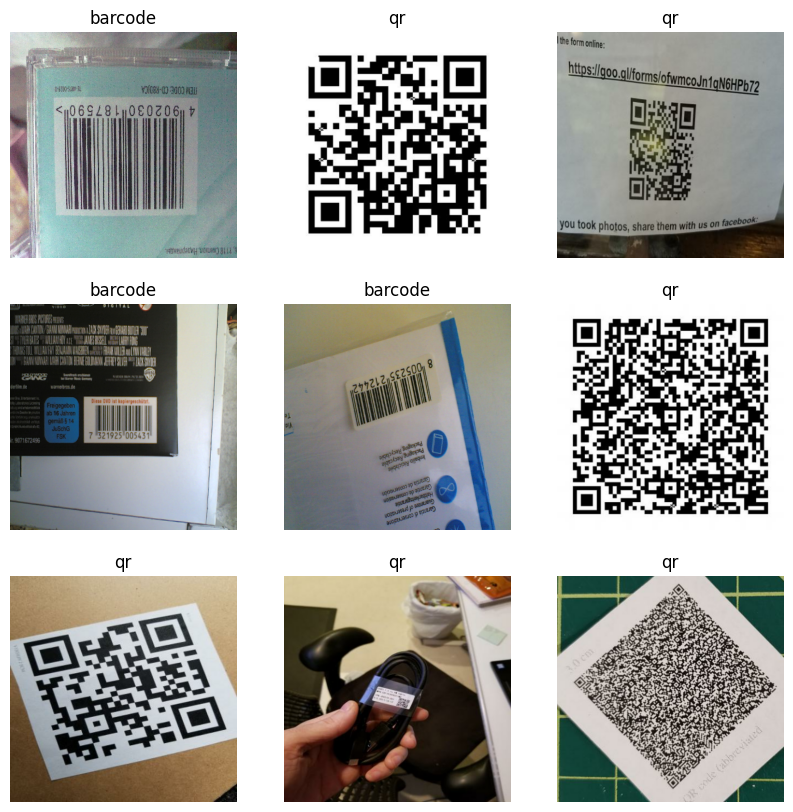

In [7]:
# Check the images
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[np.argmax(labels[i])])
        plt.axis("off")

## 2. Data Preprocessing <a id="preprocess"></a>
### 2.1 Normalisasi Gambar

Kita akan melakukan normalisasi gambar dengan mengubah nilai piksel dari rentang [0, 255] menjadi [0, 1].

In [9]:
def normalize(image, label):
    return tf.cast(image / 255.0, tf.float32), label

In [10]:
dataset = dataset.map(normalize)

# Cek nilai minimum dan maksimum dari gambar
for image_batch, labels_batch in dataset:
    print(image_batch[0].numpy().min())
    print(image_batch[0].numpy().max())
    break

0.0
1.0


### 2.2 Membagi Data
Kita akan membagi dataset menjadi set pelatihan dan pengujian menggunakan metode `take` dan `skip` dari objek `tf.data.Dataset`.

In [11]:
def split_dataset(dataset, train_size=0.8, val_size=0.1, test_size=0.1):
    if dataset is None:
        return None

    dataset_size = len(dataset)
    train_size = int(train_size * dataset_size)
    val_size = int(val_size * dataset_size)
    test_size = int(test_size * dataset_size)
    
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size).take(test_size)
    
    return train_dataset, val_dataset, test_dataset

In [12]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset)

# Cek jumlah gambar di setiap dataset
print(f'Train: {len(train_dataset) * BATCH_SIZE}')
print(f'Val: {len(val_dataset) * BATCH_SIZE}')
print(f'Test: {len(test_dataset) * BATCH_SIZE}')

Train: 768
Val: 96
Test: 96


## 3. Membangun Model <a id="model"></a>
### 3.1 Membangun Arsitektur Model

Kita akan membuat model Convolutional Neural Network (CNN) menggunakan kelas `tf.keras.Sequential`.
Kemudian, kita akan mengkompilasi model menggunakan optimizer `adam` dan fungsi loss `categorical_crossentropy`.

In [31]:
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    print(model.summary())

    return model

### 3.2 Melatih Model
Kita akan melatih model menggunakan set pelatihan dan memvalidasinya menggunakan set pengujian.

Kita juga menggunakan callback `EarlyStopping` untuk menghentikan pelatihan jika loss validasi tidak membaik setelah sejumlah epoch tertentu.

In [32]:
model = build_model((IMG_WIDTH, IMG_HEIGHT, 3), 3)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, start_from_epoch=3)
]

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=callbacks)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_15 (Ba  (None, 400, 400, 3)       12        
 tchNormalization)                                               
                                                                 
 conv2d_24 (Conv2D)          (None, 398, 398, 64)      1792      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 199, 199, 64)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_16 (Ba  (None, 199, 199, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_25 (Conv2D)          (None, 197, 197, 128)     73856     
                                                      

## 4. Evaluasi Model <a id="evaluate"></a>
### 4.1 Akurasi
Kita akan mengevaluasi akurasi model menggunakan set pengujian.

Pertama, kita akan memplot akurasi pelatihan dan validasi untuk melihat bagaimana model berperforma selama pelatihan.

Kemudian, kita akan menghitung akurasi model menggunakan set pengujian.

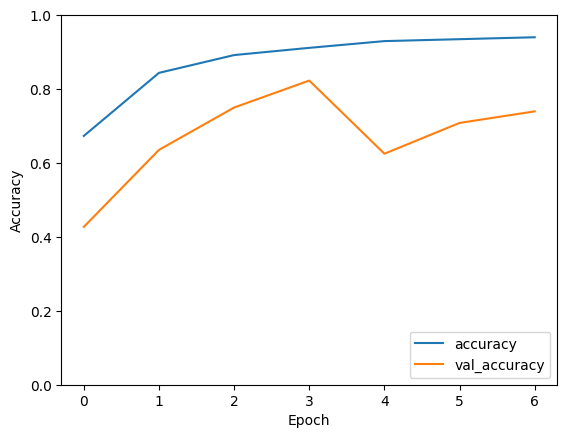

In [33]:
# Check the training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [34]:
# Evaluasi model
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy:', accuracy)
print('Test loss:', loss)

3/3 [==============================] - 1s 55ms/step - loss: 0.9518 - accuracy: 0.7708
Test accuracy: 0.7708333134651184
Test loss: 0.9518014788627625


### 4.2 Confusion Matrix <a id="confusion"></a>
Kita akan membuat confusion matrix untuk memvisualisasikan kinerja model pada setiap kelas.

1/1 [==============================] - 0s 78ms/step


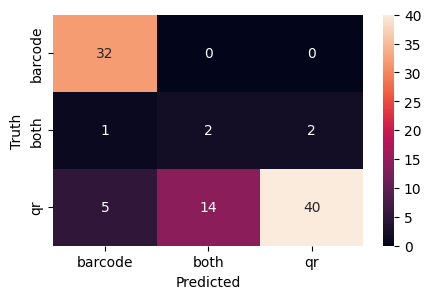

In [41]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

for x, y in test_dataset:
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(model.predict(x), axis=1))
    
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### 4.3 Classification Report <a id="report"></a>
Kita akan membuat laporan klasifikasi untuk melihat presisi, recall, dan F1-score model pada setiap kelas.

In [40]:
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

     barcode       0.84      1.00      0.91        32
        both       0.12      0.40      0.19         5
          qr       0.95      0.68      0.79        59

    accuracy                           0.77        96
   macro avg       0.64      0.69      0.63        96
weighted avg       0.87      0.77      0.80        96



## 5. Pembahasan <a id="conclusion"></a>
Akhirnya, kita akan menyimpulkan notebook ini dengan merangkum hasil dan mendiskusikan langkah selanjutnya.

Berdasarkan laporan klasifikasi, kita dapat menyimpulkan bahwa:
- Barcode: Model berperforma sangat baik dengan presisi 0.84 dan recall 1.00. Selain itu, model dapat mengidentifikasi dengan benar semua gambar barcode di set pengujian.
- Both (Barcode dan kode QR): Model kesulitan dengan gambar yang mengandung barcode dan kode QR. Meskipun model dapat mengidentifikasi dengan benar 40% gambar ini (recall), presisinya cukup rendah di 0.12, menunjukkan bahwa banyak gambar salah diidentifikasi sebagai mengandung barcode dan kode QR.
- QR Code: Model memiliki presisi tinggi 0.95 untuk kode QR, yang berarti model dapat memprediksi gambar sebagai kode QR dengan benar 95% dari waktu. Namun recallnya relatif rendah di 0.68, menunjukkan bahwa model gagal mengidentifikasi semua gambar QR code di dataset.
- Secara keseluruhan: Akurasi keseluruhan adalah 0.77, menunjukkan bahwa model mengklasifikasikan dengan benar 77% dari dataset pengujian. Nilai f1-score rata-rata tertimbang adalah 0.80, menunjukkan performa yang seimbang di semua kelas.

Hasil ini menunjukkan bahwa model mungkin memerlukan penyetelan lebih lanjut atau lebih banyak data pelatihan, terutama untuk gambar yang mengandung kedua kode. Model juga dapat mendapatkan manfaat dari teknik untuk menangani data yang tidak seimbang jika kelas 'both' sangat kurang diwakili dalam dataset.


## Ekspor Model

In [42]:
model.save('barcode_and_qr')